# Random Forest

**Loading packages**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pydot
%matplotlib inline

In [3]:
#load data
df = pd.read_csv('AmesHousing.csv')

# Separate features and target (SalePrice is the target variable)
X = df.drop(columns=['SalePrice'])
y = df['SalePrice']

In [4]:
print('The shape of the dataset is ',df.shape)

The shape of the dataset is  (2930, 82)


**EDA & Train-test split**

In [ ]:
# For regression tasks like house price prediction, we don't use stratify
# because the target is continuous, not categorical
X_train, X_test, y_train, y_test = train_test_split(
    X,  # Features (already separated from target)
    y,  # Target variable (SalePrice)
    test_size=0.33,  # 33% of data for testing
    random_state=42  # Setting random seed for reproducibility
)

print("="*80)
print("TRAIN-TEST SPLIT RESULTS")
print("="*80)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"Number of features: {X_train.shape[1]}")

print(f"\nTraining target statistics:")
print(f"  Mean price: ${y_train.mean():,.2f}")
print(f"  Median price: ${y_train.median():,.2f}")
print(f"  Price range: ${y_train.min():,.2f} - ${y_train.max():,.2f}")

print(f"\nTesting target statistics:")
print(f"  Mean price: ${y_test.mean():,.2f}")
print(f"  Median price: ${y_test.median():,.2f}")
print(f"  Price range: ${y_test.min():,.2f} - ${y_test.max():,.2f}")

# Check if the distributions are similar (important for regression)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Set transparent background for figure and axes
fig.patch.set_alpha(0.0)
ax1.patch.set_alpha(0.0)
ax2.patch.set_alpha(0.0)

# First subplot: Histogram
ax1.hist(y_train, bins=30, alpha=0.7, label='Train', color='blue', edgecolor='black')
ax1.hist(y_test, bins=30, alpha=0.7, label='Test', color='orange', edgecolor='black')
ax1.set_title('Distribution of Sale Prices', color='black')
ax1.set_xlabel('Sale Price ($)', color='black')
ax1.set_ylabel('Frequency', color='black')
ax1.legend()

# Use specific price points that make sense for housing data
price_ticks = [200000, 400000, 600000, 800000]
ax1.set_xticks(price_ticks)
ax1.set_xticklabels([f'${x/1000:.0f}K' for x in price_ticks], color='black')

# Or if you want exactly 4 labels, choose the min, max, and two intermediate points:
min_price = min(y_train.min(), y_test.min())
max_price = max(y_train.max(), y_test.max())
four_ticks = [min_price, min_price + (max_price - min_price) * 0.33, 
              min_price + (max_price - min_price) * 0.66, max_price]
ax1.set_xticks(four_ticks)
ax1.set_xticklabels([f'${x:,.0f}' for x in four_ticks], color='black')

# Second subplot: Boxplot
boxplot = ax2.boxplot([y_train, y_test], labels=['Train', 'Test'])
ax2.set_title('Boxplot of Sale Prices', color='black')
ax2.set_ylabel('Sale Price ($)', color='black')

# Make all boxplot elements visible on transparent background
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    for item in boxplot[element]:
        item.set_color('black')

# Set tick colors
ax2.tick_params(colors='black')

# Make spines visible
for ax in [ax1, ax2]:
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('black')

plt.tight_layout()
plt.savefig('train_test_split.png', dpi=600, transparent=True, 
            facecolor='none', edgecolor='none')
plt.show()

In [ ]:
# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

print(f"Categorical features: {categorical_cols}")
print(f"Numerical features: {numerical_cols}")
print(f"Total features: {len(categorical_cols) + len(numerical_cols)}")

# Create preprocessing pipelines for both data types
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols),  # Keep numerical features as-is
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)  # One-hot encode categoricals
    ])

n_feature_after_preprocessing = len(numerical_cols) + sum([X_train[col].nunique() for col in categorical_cols])
print(f"Estimated features after one-hot encoding: {n_feature_after_preprocessing}")

# Create pipeline with preprocessing and Random Forest
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=75,
        max_features=min(10, n_feature_after_preprocessing),  # Adjust for encoded features
        max_depth=10,
        random_state=42,
        oob_score=True,
        bootstrap=True
    ))
])

# Fit the pipeline
rf_pipeline.fit(X_train, y_train)

# Make predictions
y_train_pred = rf_pipeline.predict(X_train)
y_test_pred = rf_pipeline.predict(X_test)

print('='*60)
print('RANDOM FOREST REGRESSION RESULTS (WITH PREPROCESSING)')
print('='*60)

print('\nTRAINING SET PERFORMANCE:')
print(f'R² Score: {r2_score(y_train, y_train_pred):.4f}')
print(f'Mean Absolute Error: ${mean_absolute_error(y_train, y_train_pred):,.2f}')
print(f'Root Mean Squared Error: ${np.sqrt(mean_squared_error(y_train, y_train_pred)):,.2f}')

print('\nTEST SET PERFORMANCE:')
print(f'R² Score: {r2_score(y_test, y_test_pred):.4f}')
print(f'Mean Absolute Error: ${mean_absolute_error(y_test, y_test_pred):,.2f}')
print(f'Root Mean Squared Error: ${np.sqrt(mean_squared_error(y_test, y_test_pred)):,.2f}')

**Extracting the first n trees from the random forest.**

Total features after encoding: 312


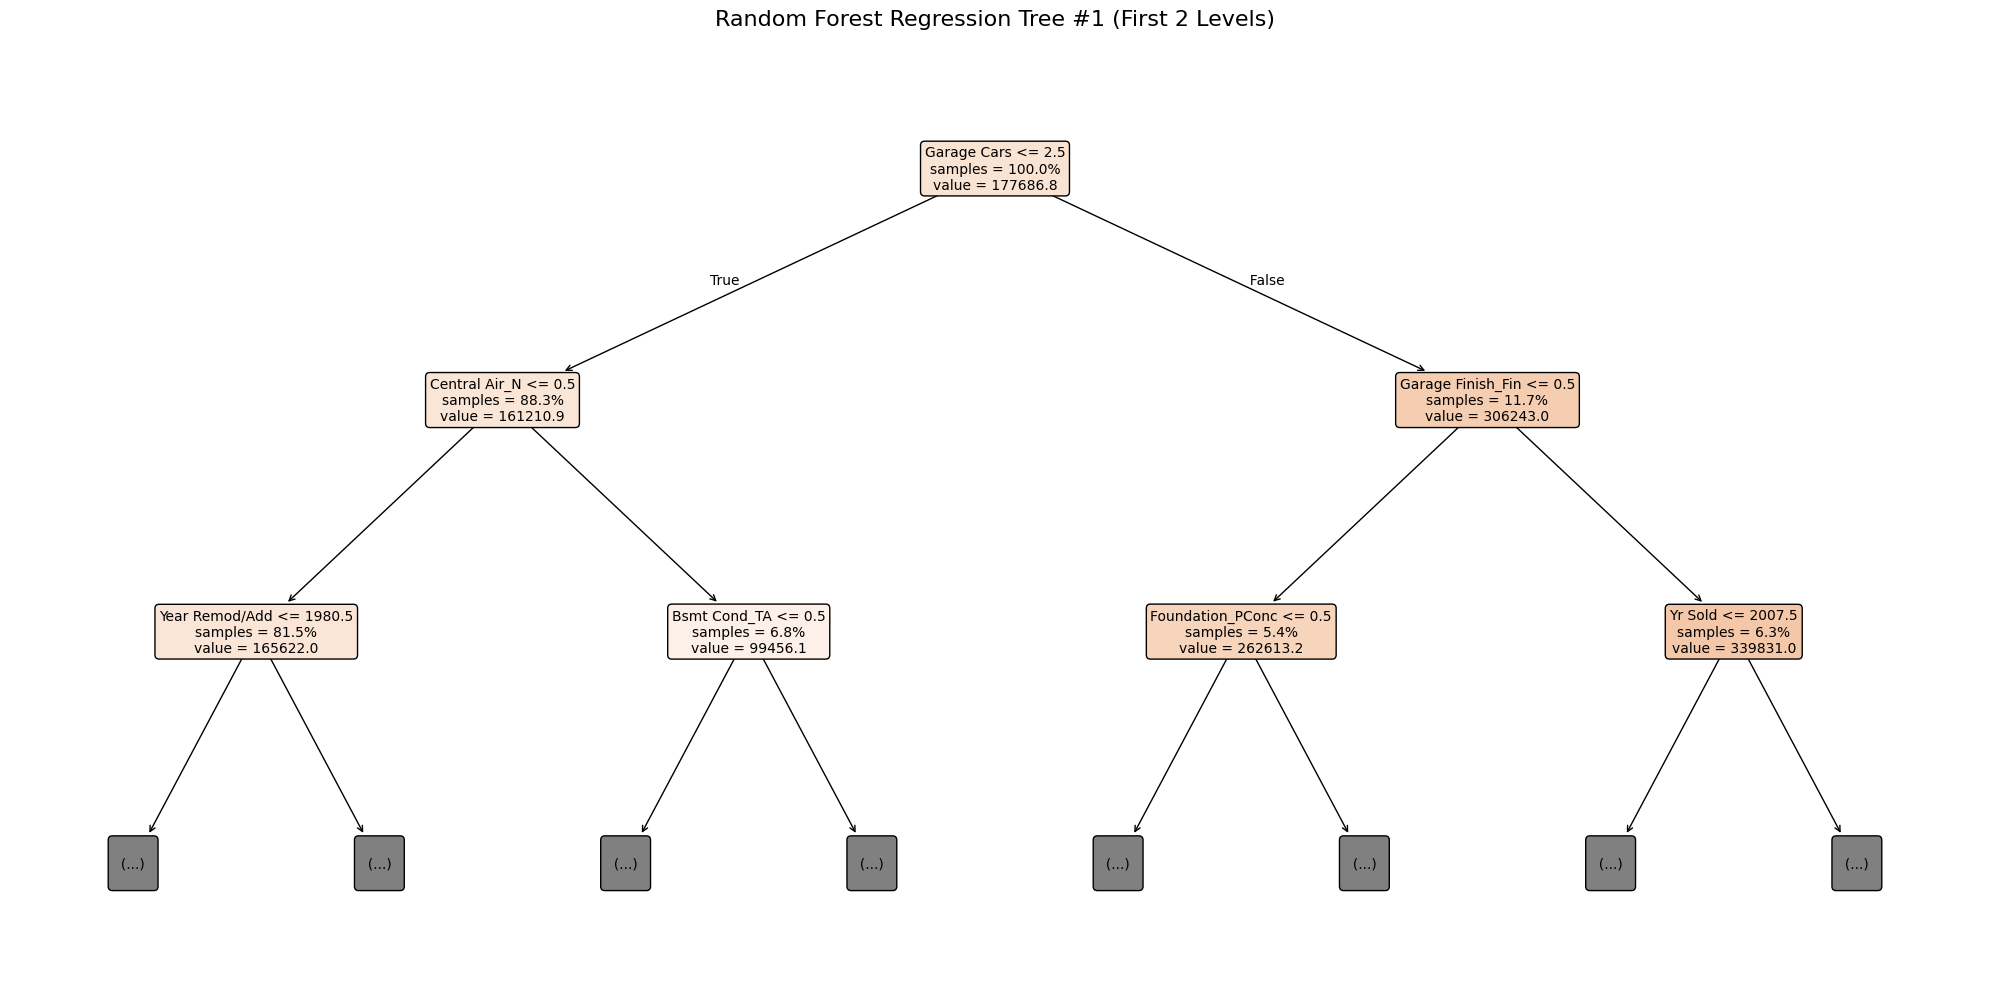

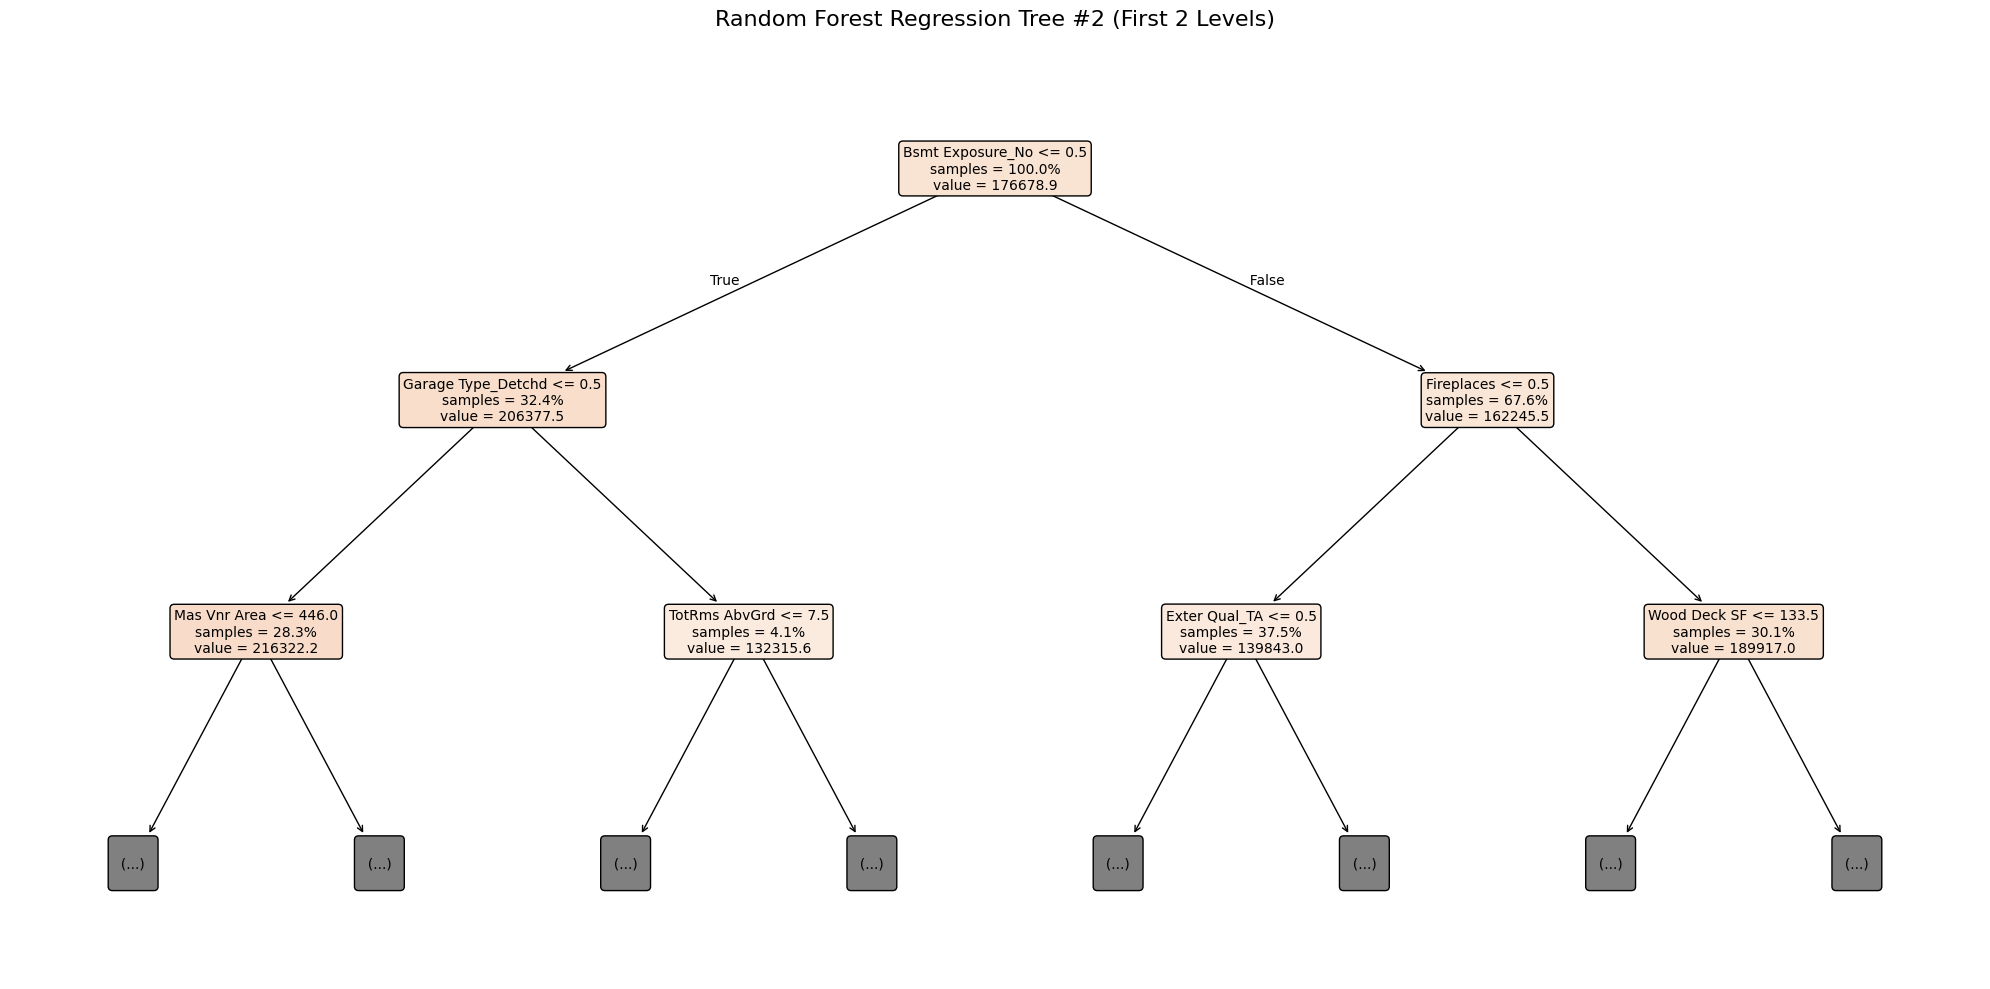

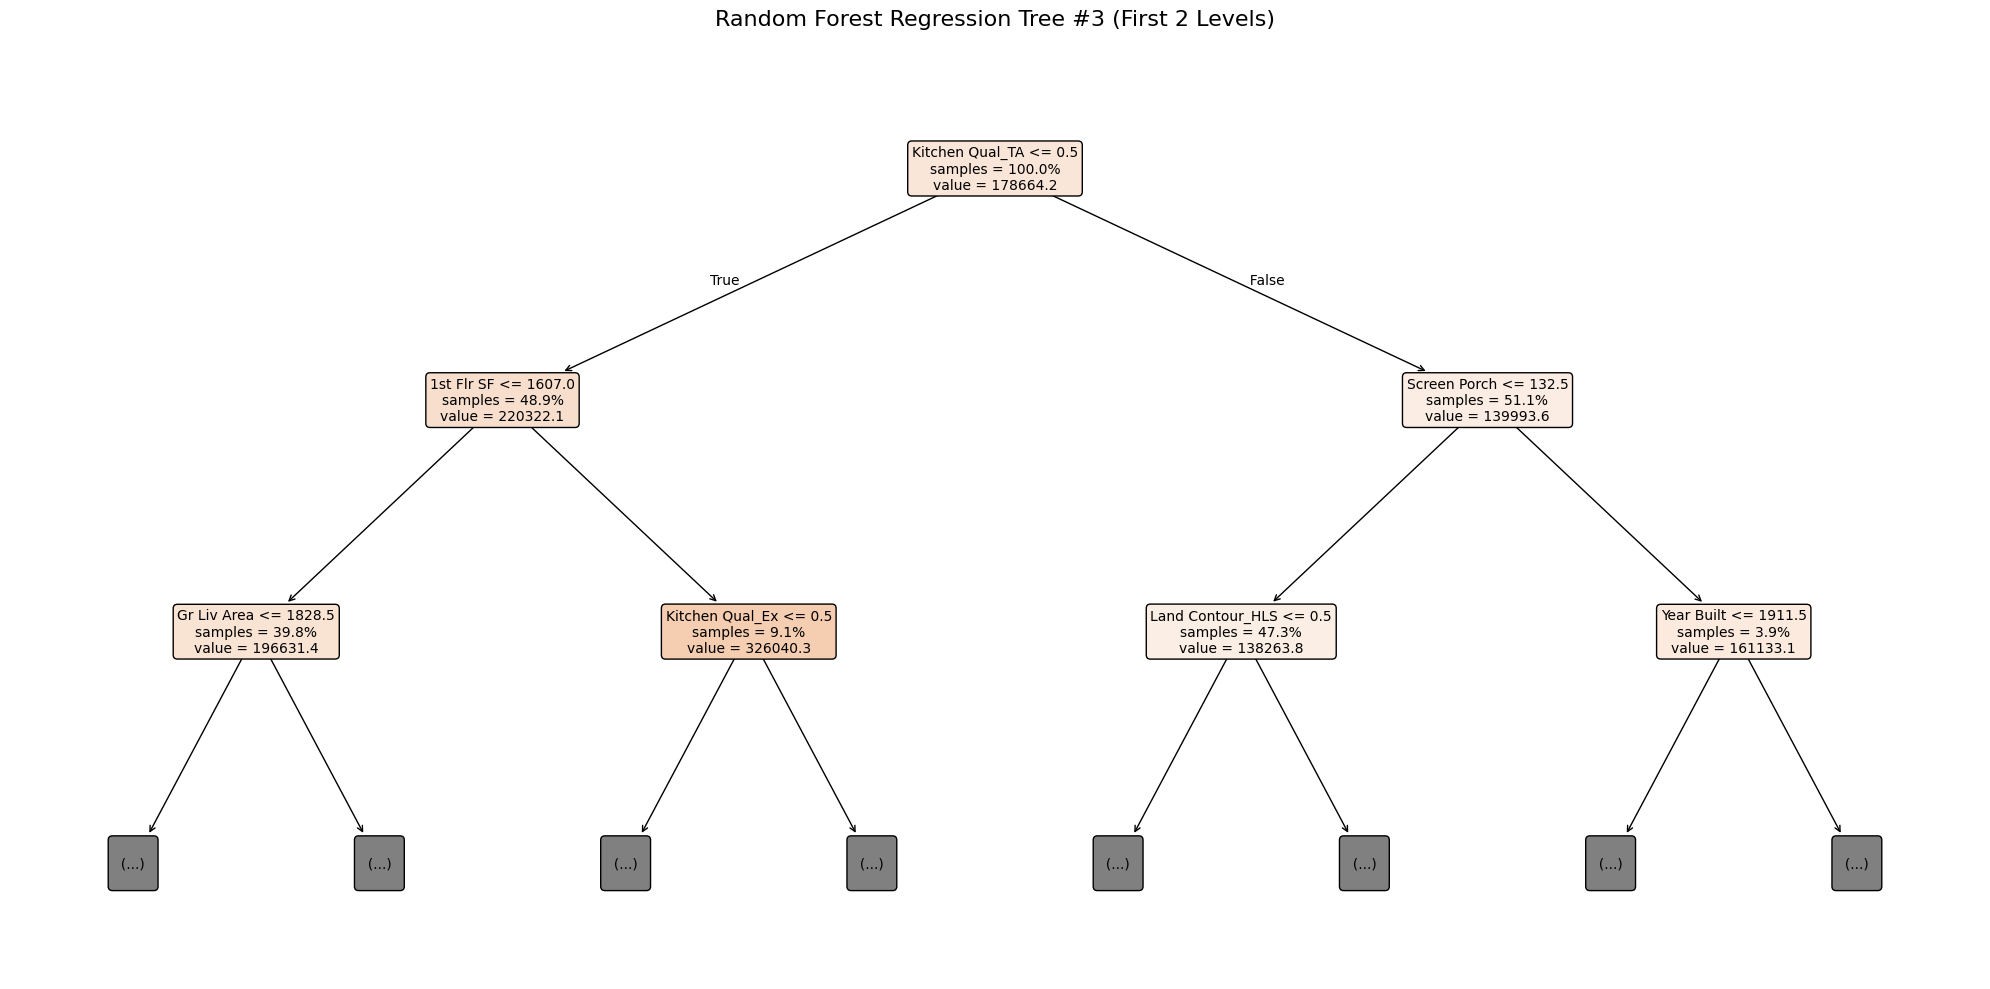

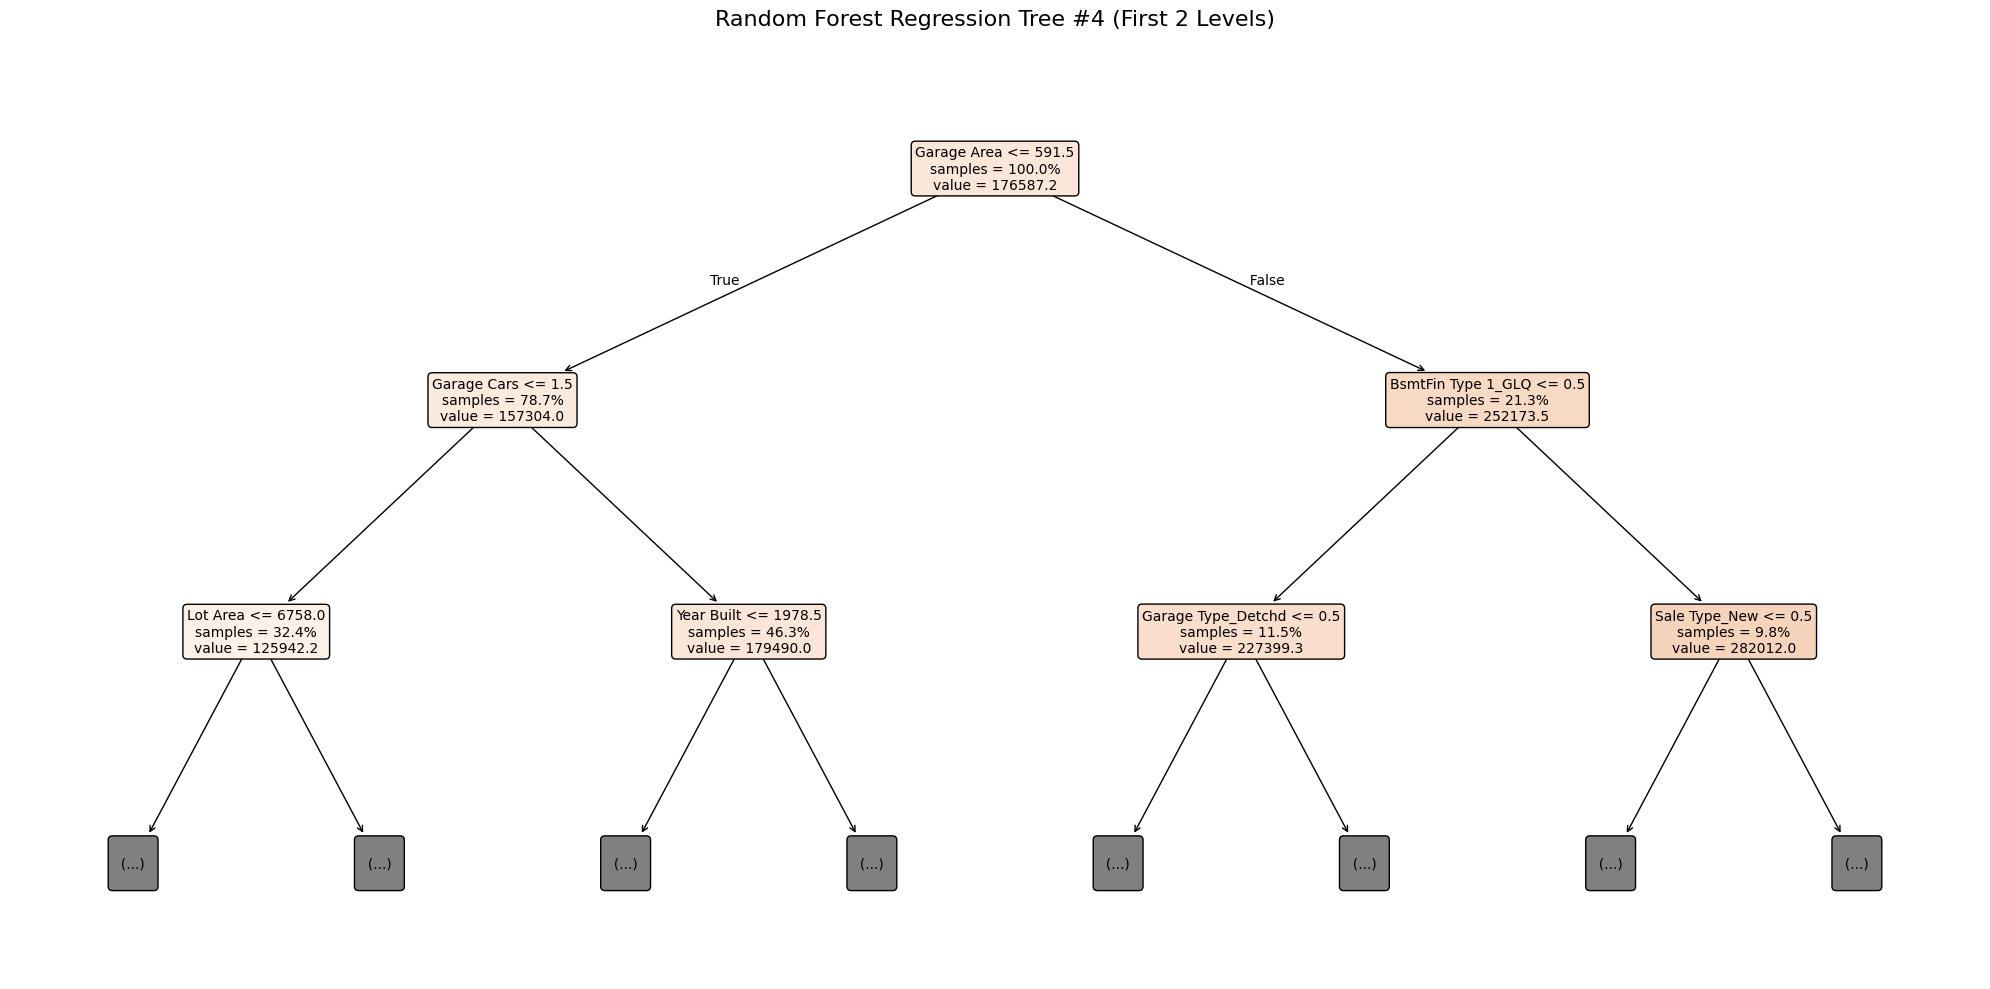

Tree visualizations completed with full transparency!


In [7]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Get the preprocessed feature names
preprocessor = rf_pipeline.named_steps['preprocessor']
rf_model = rf_pipeline.named_steps['regressor']

cat_encoder = preprocessor.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_cols)
all_feature_names = numerical_cols + list(cat_feature_names)

print(f"Total features after encoding: {len(all_feature_names)}")

num_trees = 4  # number of trees to plot

# Create visualizations with limited depth
for i in range(min(num_trees, len(rf_model.estimators_))): 
    plt.figure(figsize=(20, 10), facecolor='none')  # Transparent figure
    ax = plt.gca()
    ax.set_facecolor('none')  # Transparent axes
    
    plot_tree(
        rf_model.estimators_[i],
        feature_names=all_feature_names,
        filled=True,
        rounded=True,
        proportion=True,
        impurity=False,
        fontsize=10,
        precision=1,
        max_depth=2,  # Only show first 2 levels of the tree
        ax=ax         # Plot on the transparent axes
    )
    
    plt.title(f'Random Forest Regression Tree #{i+1} (First 2 Levels)', 
              fontsize=16, pad=20)
    
    # Remove all axes completely for full transparency
    ax.set_axis_off()
    
    plt.tight_layout()
    
    # Save with full transparency
    plt.savefig(f'RF_tree_limited_depth_{i}.png', 
                transparent=True, 
                bbox_inches='tight', 
                dpi=150,
                facecolor='none',
                edgecolor='none')
    
    plt.show(block=False)
    plt.pause(3)  # Display for 3 seconds
    plt.close()

print("Tree visualizations completed with full transparency!")

In [ ]:
# Get individual tree from the Random Forest
tree = rf_model.estimators_[3] # change index value to see different tree, 0 corresponds to 1st tree

# Make predictions with the single tree
y_train_pred_tree = tree.predict(preprocessor.transform(X_train))
y_test_pred_tree = tree.predict(preprocessor.transform(X_test))

print('='*60)
print('SINGLE DECISION TREE PERFORMANCE (from Random Forest)')
print('='*60)

print('\nTRAINING SET PERFORMANCE:')
print(f'R² Score: {tree.score(preprocessor.transform(X_train), y_train):.4f}')
print(f'Mean Absolute Error: ${mean_absolute_error(y_train, y_train_pred_tree):,.2f}')
print(f'Root Mean Squared Error: ${np.sqrt(mean_squared_error(y_train, y_train_pred_tree)):,.2f}')

print('\nTEST SET PERFORMANCE:')
print(f'R² Score: {tree.score(preprocessor.transform(X_test), y_test):.4f}')
print(f'Mean Absolute Error: ${mean_absolute_error(y_test, y_test_pred_tree):,.2f}')
print(f'Root Mean Squared Error: ${np.sqrt(mean_squared_error(y_test, y_test_pred_tree)):,.2f}')

# Compare with the full Random Forest performance
print('\n' + '='*60)
print('COMPARISON: SINGLE TREE vs FULL RANDOM FOREST')
print('='*60)
print(f"{'Metric':<25} {'Single Tree':<15} {'Random Forest':<15} {'Improvement':<15}")
print(f"{'-'*25} {'-'*15} {'-'*15} {'-'*15}")
print(f"{'Test R² Score':<25} {tree.score(preprocessor.transform(X_test), y_test):<15.4f} {r2_score(y_test, y_test_pred):<15.4f} {r2_score(y_test, y_test_pred) - tree.score(preprocessor.transform(X_test), y_test):<+15.4f}")
print(f"{'Test MAE':<25} ${mean_absolute_error(y_test, y_test_pred_tree):<13,.0f} ${mean_absolute_error(y_test, y_test_pred):<13,.0f} ${mean_absolute_error(y_test, y_test_pred_tree) - mean_absolute_error(y_test, y_test_pred):<+13,.0f}")
print(f"{'Test RMSE':<25} ${np.sqrt(mean_squared_error(y_test, y_test_pred_tree)):<13,.0f} ${np.sqrt(mean_squared_error(y_test, y_test_pred)):<13,.0f} ${np.sqrt(mean_squared_error(y_test, y_test_pred_tree)) - np.sqrt(mean_squared_error(y_test, y_test_pred)):<+13,.0f}")

 **Plotting feature importance & performance**

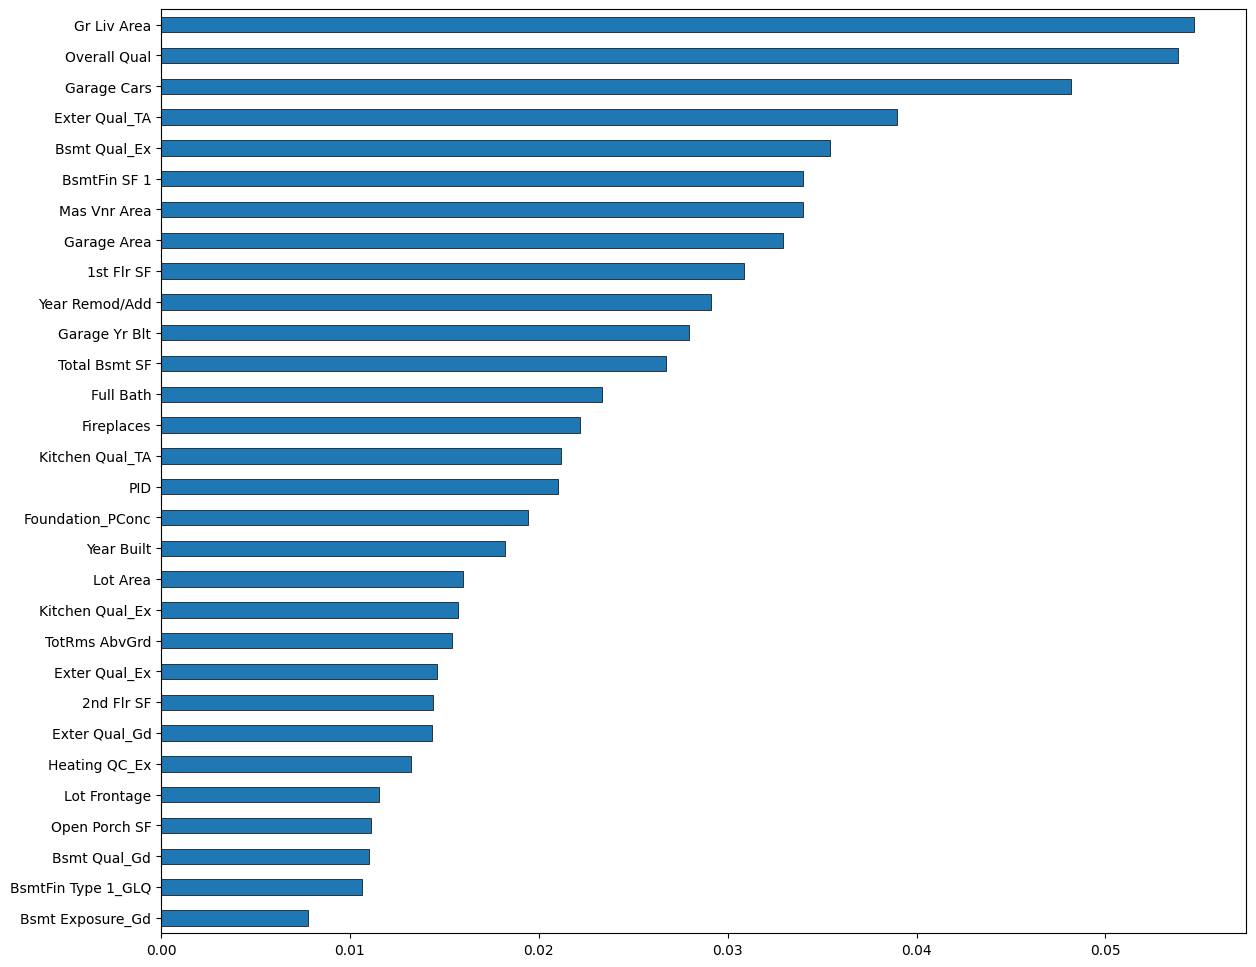

In [10]:
# Create a mapping dictionary for feature name abbreviations to full names
feature_name_mapping = {
    # Overall quality and condition
    'OverallQual': 'Overall Quality',
    'OverallCond': 'Overall Condition',
    
    # Size and area features
    'GrLivArea': 'Above Grade Living Area (sq ft)',
    'TotalBsmtSF': 'Total Basement Area (sq ft)',
    '1stFlrSF': 'First Floor Square Feet',
    '2ndFlrSF': 'Second Floor Square Feet',
    'LowQualFinSF': 'Low Quality Finished Area (sq ft)',
    'GarageArea': 'Garage Area (sq ft)',
    'WoodDeckSF': 'Wood Deck Area (sq ft)',
    'OpenPorchSF': 'Open Porch Area (sq ft)',
    'EnclosedPorch': 'Enclosed Porch Area (sq ft)',
    '3SsnPorch': 'Three Season Porch Area (sq ft)',
    'ScreenPorch': 'Screen Porch Area (sq ft)',
    'PoolArea': 'Pool Area (sq ft)',
    'LotArea': 'Lot Size (sq ft)',
    'MasVnrArea': 'Masonry Veneer Area (sq ft)',
    
    # Room counts
    'TotRmsAbvGrd': 'Total Rooms Above Grade',
    'BedroomAbvGr': 'Bedrooms Above Grade',
    'KitchenAbvGr': 'Kitchens Above Grade',
    'Fireplaces': 'Number of Fireplaces',
    'GarageCars': 'Garage Car Capacity',
    'FullBath': 'Full Bathrooms',
    'HalfBath': 'Half Bathrooms',
    'BsmtFullBath': 'Basement Full Bathrooms',
    'BsmtHalfBath': 'Basement Half Bathrooms',
    
    # Year features
    'YearBuilt': 'Original Construction Year',
    'YearRemodAdd': 'Remodel Year',
    'GarageYrBlt': 'Garage Build Year',
    'YrSold': 'Year Sold',
    
    # Location and zoning
    'MSSubClass': 'Building Class',
    'MSZoning': 'Zoning Classification',
    'LotFrontage': 'Linear Feet of Street Connected',
    'LotConfig': 'Lot Configuration',
    'Neighborhood': 'Neighborhood',
    'Condition1': 'Proximity to Various Conditions',
    'Condition2': 'Proximity to Various Conditions (if multiple)',
    
    # Quality ratings
    'ExterQual': 'Exterior Quality',
    'ExterCond': 'Exterior Condition',
    'BsmtQual': 'Basement Quality',
    'BsmtCond': 'Basement Condition',
    'HeatingQC': 'Heating Quality & Condition',
    'KitchenQual': 'Kitchen Quality',
    'FireplaceQu': 'Fireplace Quality',
    'GarageQual': 'Garage Quality',
    'GarageCond': 'Garage Condition',
    'PoolQC': 'Pool Quality',
    'Fence': 'Fence Quality',
    
    # Other features
    'Street': 'Street Access Type',
    'Alley': 'Alley Access Type',
    'LotShape': 'Lot Shape',
    'LandContour': 'Land Contour',
    'Utilities': 'Utilities Available',
    'LandSlope': 'Land Slope',
    'BldgType': 'Building Type',
    'HouseStyle': 'House Style',
    'RoofStyle': 'Roof Style',
    'RoofMatl': 'Roof Material',
    'Exterior1st': 'Exterior Covering',
    'Exterior2nd': 'Exterior Covering (Second)',
    'MasVnrType': 'Masonry Veneer Type',
    'Foundation': 'Foundation Type',
    'BsmtExposure': 'Basement Exposure',
    'BsmtFinType1': 'Basement Finished Area Type 1',
    'BsmtFinType2': 'Basement Finished Area Type 2',
    'Heating': 'Heating Type',
    'CentralAir': 'Central Air Conditioning',
    'Electrical': 'Electrical System',
    'Functional': 'Home Functionality',
    'GarageType': 'Garage Type',
    'GarageFinish': 'Garage Finish',
    'PavedDrive': 'Paved Driveway',
    'MiscFeature': 'Miscellaneous Feature',
    'MiscVal': 'Miscellaneous Feature Value',
    'MoSold': 'Month Sold',
    'SaleType': 'Sale Type',
    'SaleCondition': 'Sale Condition'
}

# Get feature importance from the trained Random Forest model
feature_imp = pd.DataFrame(
    rf_model.feature_importances_,
    index=all_feature_names,
    columns=['importance']
).sort_values('importance')

# Filter out meaningless features (those ending with _nan)
feature_imp_clean = feature_imp[~feature_imp.index.str.endswith('_nan')]

# Get only the top 30 features (most important) from cleaned data
feature_imp_top30 = feature_imp_clean.tail(30)

# For one-hot encoded features, add the category
for idx in feature_imp_top30.index:
    if '_' in idx and idx.split('_')[0] in feature_name_mapping:
        base_feature = idx.split('_')[0]
        category = '_'.join(idx.split('_')[1:])

plt.figure(figsize=(14, 12), facecolor='none')  # Transparent figure
ax = feature_imp_top30['importance'].plot(
    kind='barh',
    zorder=2,
    #color='steelblue',
    edgecolor='black',
    linewidth=0.5
)

# Set transparent background for the axes
ax.set_facecolor('none')        

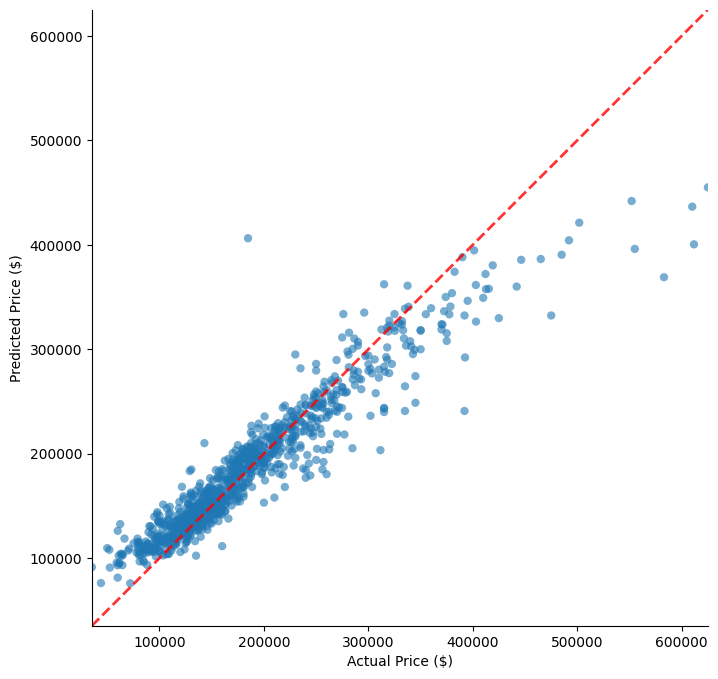

In [12]:
# Create square figure with transparent background
plt.figure(figsize=(8, 8), facecolor='none')  # Changed to square (8,8)
ax = plt.gca()
ax.set_facecolor('none')

# Scatter plot without edges
plt.scatter(y_test, y_test_pred, alpha=0.6, c='#1f77b4', edgecolor='none')

# Perfect prediction line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, alpha=0.8)

# Set equal aspect ratio to make it truly square
ax.set_aspect('equal')

# Set axis labels
plt.xlabel('Actual Price ($)', color='black')
plt.ylabel('Predicted Price ($)', color='black')

# Set axis limits to be the same for both x and y
min_val = min(y_test.min(), y_test_pred.min())
max_val = max(y_test.max(), y_test_pred.max())
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

# Remove top and right spines for cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Make remaining spines and ticks visible
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.tick_params(colors='black')

plt.savefig('actual_vs_predicted.png', transparent=True, dpi=300, 
            bbox_inches='tight', facecolor='none', edgecolor='none')
plt.show()

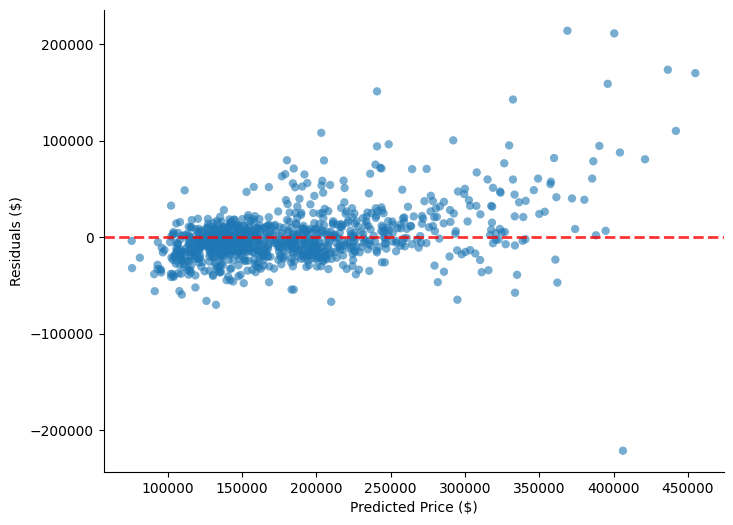

In [13]:
plt.figure(figsize=(8, 6), facecolor='none')
ax = plt.gca()
ax.set_facecolor('none')

residuals = y_test - y_test_pred
plt.scatter(y_test_pred, residuals, alpha=0.6, linewidth=0.5,  c='#1f77b4', edgecolor='none')
plt.axhline(y=0, color='red', linestyle='--', lw=2, alpha=0.8)
plt.xlabel('Predicted Price ($)')
plt.ylabel('Residuals ($)')

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig('residual_plot.png', transparent=True, dpi=300,
            bbox_inches='tight', facecolor='none', edgecolor='none')
plt.show()

In [ ]:
# Check if OOB is available, if not retrain with OOB enabled using the PIPELINE
if not hasattr(rf_model, 'oob_score_'):
    print("OOB not enabled. Retraining with OOB using pipeline...")
    
    # Create a new pipeline with OOB enabled USING GRID SEARCH OPTIMIZED PARAMETERS
    rf_oob = RandomForestRegressor(
        n_estimators=75,           # FROM GRID SEARCH
        max_features=min(10, n_feature_after_preprocessing),  # FROM GRID SEARCH
        max_depth=10,              # FROM GRID SEARCH  
        random_state=42,
        oob_score=True,            # Enable OOB
        bootstrap=True             # Required for OOB
    )
    
    # Create new pipeline
    rf_pipeline_oob = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', rf_oob)
    ])
    
    # Fit the pipeline
    rf_pipeline_oob.fit(X_train, y_train)
    rf_model = rf_pipeline_oob.named_steps['regressor']
    
    print("Getting OOB predictions with optimized parameters...")

print('='*60)
print('RANDOM FOREST OOB ERROR ANALYSIS (WITH OPTIMIZED PARAMETERS)')
print('='*60)
print(f"Using grid search optimized parameters:")
print(f"  n_estimators: 75")
print(f"  max_features: {min(10, n_feature_after_preprocessing)}")
print(f"  max_depth: 10")

# For proper OOB analysis with preprocessing, we need a different approach
# Let's use the fact that we already have a trained model with OOB
if hasattr(rf_model, 'oob_score_'):
    print(f"OOB R² Score: {rf_model.oob_score_:.4f}")
    
    # Calculate OOB errors
    oob_errors = y_train - rf_model.oob_prediction_
    oob_mae = mean_absolute_error(y_train, rf_model.oob_prediction_)
    oob_rmse = np.sqrt(mean_squared_error(y_train, rf_model.oob_prediction_))
    
    print(f"\nOOB Error Metrics:")
    print(f"OOB Mean Absolute Error: ${oob_mae:,.2f}")
    print(f"OOB Root Mean Squared Error: ${oob_rmse:,.2f}")
    
    # Alternative: Use cross-validation as a proxy for OOB-like estimation
    from sklearn.model_selection import cross_val_score
    
    print("\nUsing cross-validation as reliable error estimate...")
    
    # Perform cross-validation on the pipeline WITH OPTIMIZED PARAMETERS
    optimized_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(
            n_estimators=75,
            max_features=min(10, n_feature_after_preprocessing),
            max_depth=10,
            random_state=42
        ))
    ])
    
    cv_scores = cross_val_score(optimized_pipeline, X_train, y_train, 
                               cv=5, scoring='r2', n_jobs=-1)
    
    cv_mae_scores = cross_val_score(optimized_pipeline, X_train, y_train,
                                   cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    
    print(f"Cross-Validation R²: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    print(f"Cross-Validation MAE: ${-cv_mae_scores.mean():,.2f}")
    
    # Compare with test performance USING OPTIMIZED MODEL
    y_test_pred = optimized_pipeline.fit(X_train, y_train).predict(X_test)
    test_r2 = r2_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    print(f"\nTest Performance (Optimized Model):")
    print(f"Test R²: {test_r2:.4f}")
    print(f"Test MAE: ${test_mae:,.2f}")
    
    # Compare OOB with test performance
    print(f"\nOOB vs Test Comparison:")
    print(f"OOB R²: {rf_model.oob_score_:.4f} vs Test R²: {test_r2:.4f}")
    print(f"Difference: {abs(rf_model.oob_score_ - test_r2):.4f}")
    
    # Interpretation
    print(f"\n" + '='*60)
    print('PERFORMANCE INTERPRETATION WITH OPTIMIZED PARAMETERS')
    print('='*60)
    if abs(rf_model.oob_score_ - test_r2) < 0.05:
        print("✓ EXCELLENT: OOB and test performance are similar")
        print("  → Optimized model generalizes well to unseen data")
    else:
        print("⚠️  CAUTION: Difference between OOB and test performance")
        print("  → May indicate overfitting despite parameter optimization")

else:
    # Fallback: Use normal training if OOB isn't available
    print("OOB not available. Using standard training with optimized parameters...")
    optimized_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(
            n_estimators=75,
            max_features=min(10, n_feature_after_preprocessing),
            max_depth=10,
            random_state=42
        ))
    ])
    
    optimized_pipeline.fit(X_train, y_train)
    y_train_pred = optimized_pipeline.predict(X_train)
    y_test_pred = optimized_pipeline.predict(X_test)
    
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    print(f"Train R²: {train_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")
    print(f"Test MAE: ${test_mae:,.2f}")

In [20]:
lab = ['Overall Qual', 'Gr Liv Area']
feature_columns = []
for feature in lab:  # lab contains ['Overall Qual', 'Gr Liv Area']
    # Find the actual column name in the original dataframe
    # This reverses our feature_name_mapping to find the original column name
    reverse_mapping = {v: k for k, v in feature_name_mapping.items()}
    original_col = reverse_mapping.get(feature, feature)
    feature_columns.append(original_col)

print(f"Using columns: {feature_columns}")

# Simple and robust approach using np.linspace
s = 100  # resolution

# Get ranges for both features
x1_min, x1_max = X_train[feature_columns[0]].min(), X_train[feature_columns[0]].max()
x2_min, x2_max = X_train[feature_columns[1]].min(), X_train[feature_columns[1]].max()

# Add 10% padding
x1_min, x1_max = x1_min - 0.1 * (x1_max - x1_min), x1_max + 0.1 * (x1_max - x1_min)
x2_min, x2_max = x2_min - 0.1 * (x2_max - x2_min), x2_max + 0.1 * (x2_max - x2_min)

# Create mesh grid
xx, yy = np.meshgrid(
    np.linspace(x1_min, x1_max, s),
    np.linspace(x2_min, x2_max, s)
)

print(f"Mesh grid created with shape: {xx.shape}")

Using columns: ['Overall Qual', 'Gr Liv Area']
Mesh grid created with shape: (100, 100)


## Comparison

### Accuracy vs. number of trees

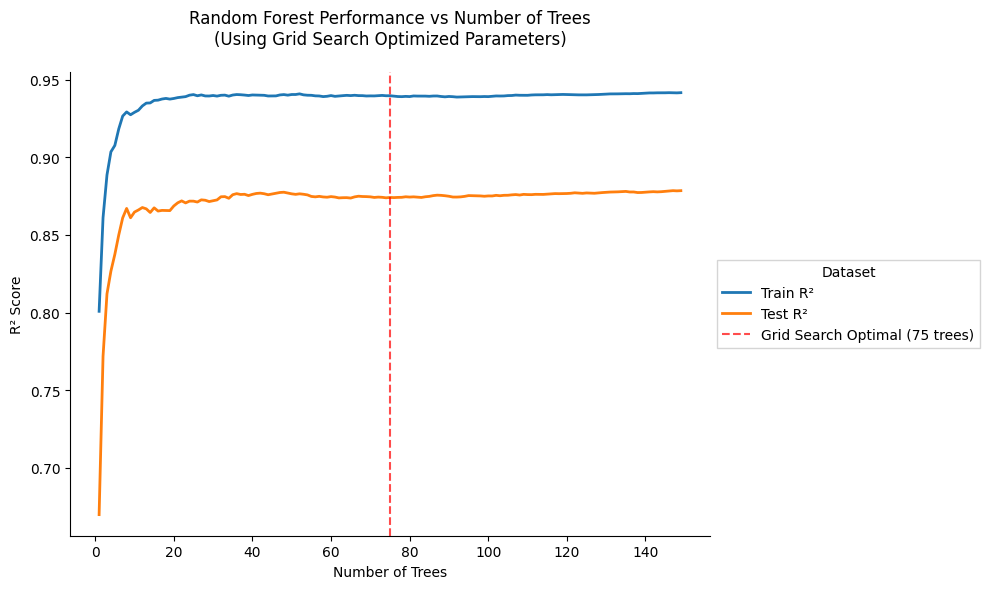

In [27]:
# First, preprocess the data to handle categorical variables
X_train_encoded = preprocessor.transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

# Get the number of features after preprocessing
n_features_encoded = X_train_encoded.shape[1]

# Use the GRID SEARCH OPTIMIZED parameters
rf = RandomForestRegressor(
    n_estimators=75,  # FROM GRID SEARCH
    max_features=min(10, n_features_encoded),  # FROM GRID SEARCH
    max_depth=10,  # FROM GRID SEARCH
    random_state=42,
)

res = []
for i in range(1, 150, 1):
    rf.n_estimators = i
    rf.fit(X_train_encoded, y_train)  # Use encoded training data
    d = dict({'n_estimators': i})
    d.update({'train_r2': rf.score(X_train_encoded, y_train)})  # R² for training
    d.update({'test_r2': rf.score(X_test_encoded, y_test)})     # R² for testing
    res.append(d)

res = pd.DataFrame(res)

# Create the plot with full transparency
plt.figure(figsize=(10, 6), facecolor='none')
ax = plt.gca()
ax.set_facecolor('none')

# Plot R² scores
plt.plot(res['n_estimators'], res['train_r2'], label='Train R²', linewidth=2)
plt.plot(res['n_estimators'], res['test_r2'], label='Test R²', linewidth=2)

# Add vertical line at the grid search optimal point
plt.axvline(x=75, color='red', linestyle='--', alpha=0.7, label='Grid Search Optimal (75 trees)')

plt.ylabel('R² Score')
plt.xlabel('Number of Trees')
plt.title('Random Forest Performance vs Number of Trees\n(Using Grid Search Optimized Parameters)', pad=20)

# Remove spines for transparency
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Dataset', fancybox=False)
plt.tight_layout()

# Save with full transparency
plt.savefig('RF_r2_number_of_trees_optimized.png', 
            dpi=300, 
            transparent=True,
            bbox_inches='tight',
            facecolor='none',
            edgecolor='none')

plt.show()

### Accuracy vs. Number of Samples per leaf

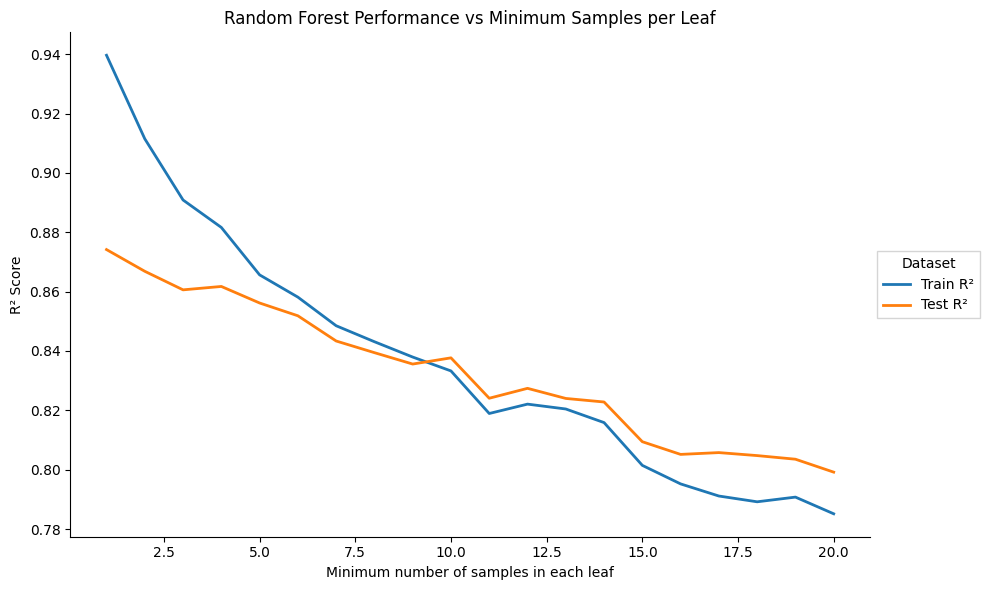

In [28]:
# Preprocess the data first
X_train_encoded = preprocessor.transform(X_train)
X_test_encoded = preprocessor.transform(X_test)
n_features_encoded = X_train_encoded.shape[1]

# Use grid search optimized parameters
rf = RandomForestRegressor(
    n_estimators=75,
    max_features=min(10, n_features_encoded),
    max_depth=10,
    random_state=42,
)

min_sample_leaf_range = range(1, 21)  # Reasonable range for min_samples_leaf
res = []
for i in min_sample_leaf_range:
    rf.min_samples_leaf = i
    rf.fit(X_train_encoded, y_train)
    d = dict({'min_samples_leaf': i})
    d.update({'train_r2': rf.score(X_train_encoded, y_train)})
    d.update({'test_r2': rf.score(X_test_encoded, y_test)})
    res.append(d)

res = pd.DataFrame(res)

# Create the plot with full transparency
plt.figure(figsize=(10, 6), facecolor='none')
ax = plt.gca()
ax.set_facecolor('none')

# Plot R² scores
plt.plot(res['min_samples_leaf'], res['train_r2'], label='Train R²', linewidth=2)
plt.plot(res['min_samples_leaf'], res['test_r2'], label='Test R²', linewidth=2)

plt.ylabel('R² Score')
plt.xlabel('Minimum number of samples in each leaf')
plt.title('Random Forest Performance vs Minimum Samples per Leaf')

# Remove spines for transparency
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Dataset', fancybox=False)
plt.tight_layout()

# Save with full transparency
plt.savefig('RF_r2_min_samples_leaf.png', 
            dpi=300, 
            transparent=True,
            bbox_inches='tight',
            facecolor='none',
            edgecolor='none')

plt.show()

### Accuracy vs. Maximum features

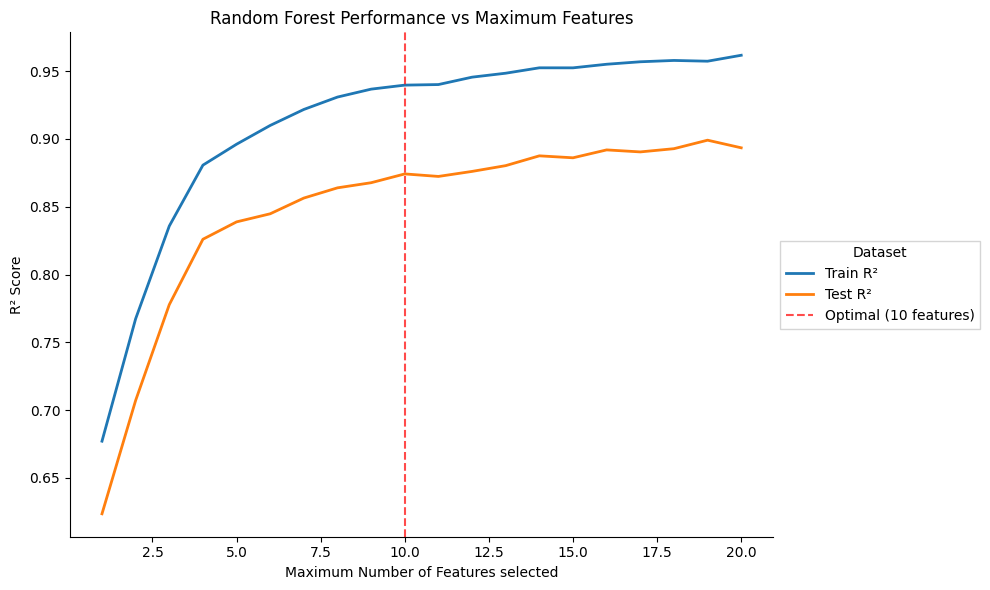

In [29]:
# Preprocess the data first
X_train_encoded = preprocessor.transform(X_train)
X_test_encoded = preprocessor.transform(X_test)
n_features_encoded = X_train_encoded.shape[1]

# Use grid search optimized parameters
rf = RandomForestRegressor(
    n_estimators=75,
    max_depth=10,
    random_state=42,
)

res = []
for i in range(1, min(21, n_features_encoded + 1)):  # Limit to first 20 features
    rf.max_features = i
    rf.fit(X_train_encoded, y_train)
    d = dict({'max_features': i})
    d.update({'train_r2': rf.score(X_train_encoded, y_train)})
    d.update({'test_r2': rf.score(X_test_encoded, y_test)})
    res.append(d)

res = pd.DataFrame(res)

# Create the plot with full transparency
plt.figure(figsize=(10, 6), facecolor='none')
ax = plt.gca()
ax.set_facecolor('none')

# Plot R² scores
plt.plot(res['max_features'], res['train_r2'], label='Train R²', linewidth=2)
plt.plot(res['max_features'], res['test_r2'], label='Test R²', linewidth=2)

# Add vertical line at grid search optimal value
optimal_max_features = min(10, n_features_encoded)
plt.axvline(x=optimal_max_features, color='red', linestyle='--', alpha=0.7, label=f'Optimal ({optimal_max_features} features)')

plt.ylabel('R² Score')
plt.xlabel('Maximum Number of Features selected')
plt.title('Random Forest Performance vs Maximum Features')

# Remove spines for transparency
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Dataset', fancybox=False)
plt.tight_layout()

# Save with full transparency
plt.savefig('RF_r2_max_features.png', 
            dpi=300, 
            transparent=True,
            bbox_inches='tight',
            facecolor='none',
            edgecolor='none')

plt.show()